In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hansamaldharmananda","key":"d183c1852f764192e21faf8a6ca7352c"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 75 Apr 29 01:25 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-28 17:13:57           3815  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2219  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            474  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1410  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
!kaggle datasets download -d nikhilroxtomar/person-segmentation

 95% 438M/461M [00:03<00:00, 229MB/s]
100% 461M/461M [00:03<00:00, 135MB/s]


In [ ]:
ls

kaggle.json  person-segmentation.zip  sample_data/


In [ ]:
!unzip person-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: people_segmentation/masks/pexels-photo-108155.png  
  inflating: people_segmentation/masks/pexels-photo-108157.png  
  inflating: people_segmentation/masks/pexels-photo-108261.png  
  inflating: people_segmentation/masks/pexels-photo-108292.png  
  inflating: people_segmentation/masks/pexels-photo-109002.png  
  inflating: people_segmentation/masks/pexels-photo-109394.png  
  inflating: people_segmentation/masks/pexels-photo-109547_rIJj622db8.png  
  inflating: people_segmentation/masks/pexels-photo-109669.png  
  inflating: people_segmentation/masks/pexels-photo-10979.png  
  inflating: people_segmentation/masks/pexels-photo-109851.png  
  inflating: people_segmentation/masks/pexels-photo-10988.png  
  inflating: people_segmentation/masks/pexels-photo-109917.png  
  inflating: people_segmentation/masks/pexels-photo-109920.png  
  inflating: people_segmentation/masks/pexels-photo-110080.png  
  inflating: people_segmentati

In [ ]:
!ls

kaggle.json  people_segmentation  person-segmentation.zip  sample_data


In [ ]:
!cd people_segmentation

In [ ]:
!ls

kaggle.json  people_segmentation  person-segmentation.zip  sample_data


##

# CODE data

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    # x = x/255.0
    # x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def load_dataset(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)

    return (train_x, train_y), (test_x, test_y)

def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()

        x = read_image(image_path)
        y = read_mask(mask_path)

        return x, y

    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    return image, mask

def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset


In [ ]:
dataset_path = r'/content/people_segmentation'
(train_x, train_y), (test_x, test_y) = load_dataset(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=8)

Train: 4542 - 4542
Test: 1136 - 1136


# Model Design

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)         # 512


    # encoder
    s1, p1 = encoder_block(inputs, 64)  # 256
    s2, p2 = encoder_block(p1, 128)     # 128
    s3, p3 = encoder_block(p2, 256)     # 64
    s4, p4 = encoder_block(p3, 512)     # 32

    # bridge
    b1 = conv_block(p4, 1024)

    # decoder
    d1 = decoder_block(b1, s4, 512)     # 
    d2 = decoder_block(d1, s3, 256)     # 
    d3 = decoder_block(d2, s2, 128)     # 
    d4 = decoder_block(d3, s1, 64)      # 

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
# input_shape = (512, 512, 3)
# model = build_unet(input_shape)
# # model.summary()

# **Train the Model**

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import tensorflow as tf
# from model import build_unet
# from data import load_dataset, tf_dataset
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

# if __name__ == "__main__":
""" Hyperparamaters """
dataset_path = r'/content/people_segmentation'
input_shape = (256, 256, 3)
batch_size = 12
epochs = 10
lr = 1e-4
model_path = r'/content/people_segmentation/unet.h5'
csv_path = r'/content/people_segmentation/data.csv'

""" Load the dataset """
(train_x, train_y), (test_x, test_y) = load_dataset(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

""" Model """
model = build_unet(input_shape)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        ['accuracy']
    ]
)

    # model.summary()

callbacks = [
    ModelCheckpoint(model_path, monitor="val_loss", verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=10)
]

train_steps = len(train_x)//batch_size
if len(train_x) % batch_size != 0:
    train_steps += 1

test_steps = len(test_x)//batch_size
if len(test_x) % batch_size != 0:
    test_steps += 1

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

Train: 4542 - 4542
Test: 1136 - 1136
Epoch 1/10
379/379 [==============================] - 279s 730ms/step - loss: 0.5301 - mean_io_u_1: 0.3732 - recall_1: 0.6319 - precision_1: 0.5062 - accuracy: 0.7291 - val_loss: 0.4152 - val_mean_io_u_1: 0.3721 - val_recall_1: 0.5193 - val_precision_1: 0.7057 - val_accuracy: 0.8217

Epoch 00001: saving model to /content/people_segmentation/unet.h5
Epoch 2/10
379/379 [==============================] - 276s 727ms/step - loss: 0.3182 - mean_io_u_1: 0.3740 - recall_1: 0.6938 - precision_1: 0.7521 - accuracy: 0.8652 - val_loss: 0.3130 - val_mean_io_u_1: 0.3721 - val_recall_1: 0.8260 - val_precision_1: 0.6994 - val_accuracy: 0.8647

Epoch 00002: saving model to /content/people_segmentation/unet.h5
Epoch 3/10
379/379 [==============================] - 277s 730ms/step - loss: 0.2791 - mean_io_u_1: 0.3739 - recall_1: 0.7429 - precision_1: 0.7887 - accuracy: 0.8848 - val_loss: 0.2799 - val_mean_io_u_1: 0.3721 - val_recall_1: 0.6449 - val_precision_1: 0.8453 

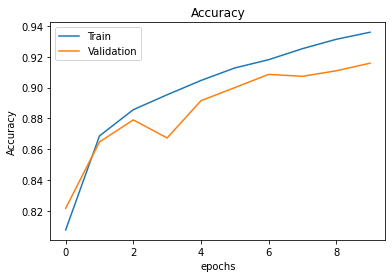

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

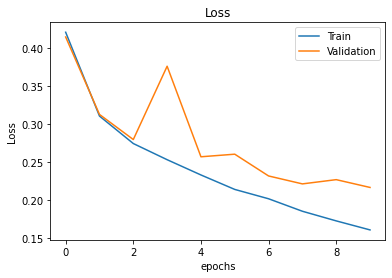

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Validation")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

# Testing model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm

if __name__ == "__main__":
    """ Load the test images """
    test_images = glob("/content/people_segmentation/test_images/*")

    """ Load the model """
    model = tf.keras.models.load_model("/content/people_segmentation/unet.h5")

    for path in tqdm(test_images, total=len(test_images)):
        x = cv2.imread(path, cv2.IMREAD_COLOR)
        original_image = x
        h, w, _ = x.shape

        x = cv2.resize(x, (256, 256))
        x = x/255.0
        x = x.astype(np.float32)

        x = np.expand_dims(x, axis=0)
        pred_mask = model.predict(x)[0]

        pred_mask = np.concatenate(
            [
                pred_mask,
                pred_mask,
                pred_mask
            ], axis=2)
        pred_mask = (pred_mask > 0.5) * 255
        pred_mask = pred_mask.astype(np.float32)
        pred_mask = cv2.resize(pred_mask, (w, h))

        original_image = original_image.astype(np.float32)

        alpha = 0.6
        cv2.addWeighted(pred_mask, alpha, original_image, 1-alpha, 0, original_image)

        name = path.split("/")[-1]
        cv2.imwrite(f"/content/people_segmentation/save_images/{name}", original_image)

100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
